# Machine Learning

### Bibliotecas utilizadas

In [1]:
import folium
import pandas as pd
import time
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
import warnings
import timeout_decorator
warnings.filterwarnings("ignore")

### Plotando LOS/NLOS no mapa

A medição realizada separou os sinais LOS e NLOS em dois arquivos diferentes, "Dados_diversos_LOS.csv" e "Dados_diversos_NLOS.csv", respectivamente. Com isso, foi criado dois dataframes separados com o conteúdo da medição de cada um deles.

Entretanto, não consta, nos arquivos, uma coluna para indicar a presença de linha de visada ou não em cada um desses arquivos, portanto foi adicionada uma coluna para indicar a presença de visada no dataframe. 

Visada = 1 indica um sinal do tipo LOS,
Visada = 0 indica um sinal do tipo NLOS.


A partir disso, foi criado um mapa com os pontos os pontos coletados na campanha de medição. De azul estão os LOS, de vermelho os NLOS e de preto a localização do Gateway. O mapa completo com os pontos pode ser visualizado pelo arquivo "mapa_interativo_completo.html"

In [2]:

df_completo_LOS = pd.read_csv("Dados_diversos_LOS.csv") # Dados de posição LOS
df_completo_NLOS = pd.read_csv("Dados_diversos_NLOS.csv") # Dados de posição NLOS

# Criar um mapa centrado em uma localização inicial
latitude_central = df_completo_LOS['Latitude'].mean()
longitude_central = df_completo_LOS['Longitude'].mean()
mapa = folium.Map(location=[latitude_central, longitude_central], zoom_start=30, max_zoom=200)

# Adicionar marcadores para cada conjunto de coordenadas no DataFrame
df_completo_LOS = df_completo_LOS.assign(Visada=1)      # Adicionando coluna com Visada igual a 1
df_completo_NLOS = df_completo_NLOS.assign(Visada=0)    # Adicionando coluna com Visada igual a 0
GW_pos = [-21.77886349497853, -43.37347360887864]   # latitude/longitude do Gateway

folium.CircleMarker(location=[GW_pos[0],GW_pos[1]],color='black').add_to(mapa)  # Marcador do GW no mapa

for index, row in df_completo_LOS.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],color='blue').add_to(mapa)     # Marcador dos pontos LOS no mapa

    
for index, row in df_completo_NLOS.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],color='red').add_to(mapa)      # Marcador dos pontos NLOS no mapa
    
mapa.save('Mapa/mapa_interativo_completo.html')  # Mapa completo


### União LOS/NLOS


Unindo os Dataframes de LOS e NLOS em um único DataFrame

In [3]:
df_final = pd.concat([df_completo_LOS, df_completo_NLOS])   # Concatenação


### Adicionando distância do gateway

Uma análise para visualizar a distância euclidiana entre o gateway e  cada um dos pontos de coleta da campanha de medição

In [4]:
df_final = df_final.assign(Distância=0) # Coluna distância

In [ ]:
alt_ini = 923.3       # Altitude do  GW
tamanho_predio = 13   # Altura do prédio Itamar
comp_antena = 1.8     # Comprimento da antena

alt_ini = alt_ini + tamanho_predio + comp_antena


for index, row in df_final.iterrows():
  lat_final = row['Latitude']
  longi_final = row['Longitude']
  alt_final = row['Altitude']
  flat_distance = distance.distance((GW_pos[0], GW_pos[1]), (lat_final,longi_final)).meters
  euclidian_distance = math.sqrt(flat_distance**2 + (alt_final - alt_ini)**2)
  df_final.at[index,'Distância'] = euclidian_distance




C:\Users\User\AppData\Local\Temp\ipykernel_20076\744632912.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '138.01984707920772' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final.at[index,'Distância'] = euclidian_distance


In [ ]:
df_final

,Time,GPS Time,id,Latitude,Longitude,Altitude,GPS Precision,# Satellites,ED RSSI,GW RSSI,Visada,Distância
0,18:44:32,21:44:24,33,-21.777797,-43.374139,918.7,1,14,-104,-85,1,226.487957
1,18:44:40,21:44:32,34,-21.778067,-43.374374,921.1,1,14,-101,-97,1,226.487957
2,18:45:13,21:45:04,38,-21.779387,-43.374631,922.3,1,14,-88,-87,1,226.486135
3,18:45:21,21:45:13,39,-21.779459,-43.374125,923.9,1,14,-91,-84,1,226.487448
4,18:45:29,21:45:21,40,-21.779385,-43.373685,924.6,1,14,-88,-76,1,226.481052
...,...,...,...,...,...,...,...,...,...,...,...,...
567,16:53:39,19:53:31,471,-21.772752,-43.366115,895.7,1,13,-99,-99,0,1019.325734
568,16:53:47,19:53:39,472,-21.772753,-43.366199,895.6,1,13,-101,-102,0,1012.733837
569,16:53:55,19:53:47,473,-21.772771,-43.366277,895.8,1,13,-112,-103,0,1005.381778
570,16:54:03,19:53:55,474,-21.772808,-43.366326,896.1,1,12,-100,-100,0,998.838692


### Análise de correlação linear

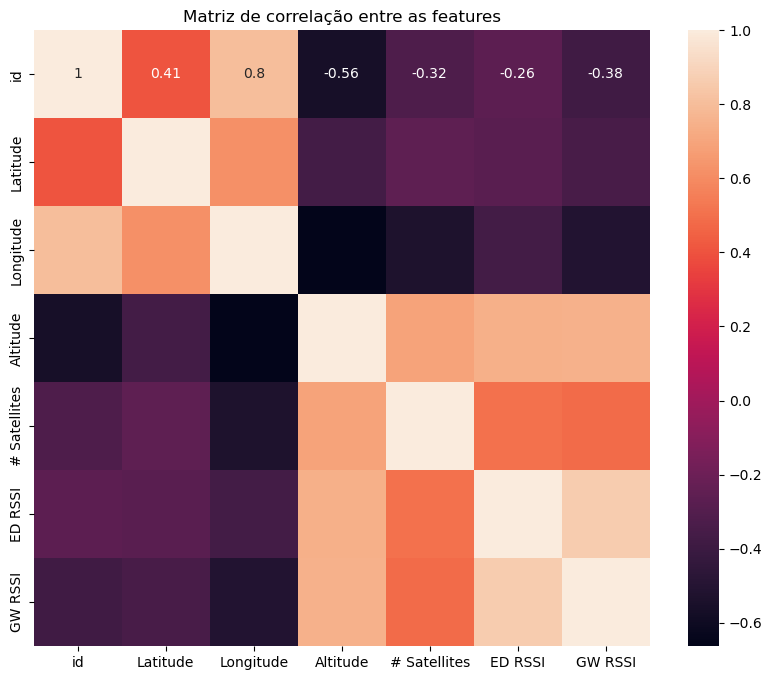

In [ ]:
# Matriz de correlação entre as features
plt.subplots(figsize=(10, 8))
plt.title('Matriz de correlação entre as features')
X = df_final.loc[:,['id','Latitude','Longitude','Altitude',
                    '# Satellites', 'ED RSSI', 'GW RSSI', ]]

sns.heatmap(X.corr(), vmax=1.0, square=True,annot=True)

plt.savefig('Figuras/fig1 - Matriz correl')
plt.show()

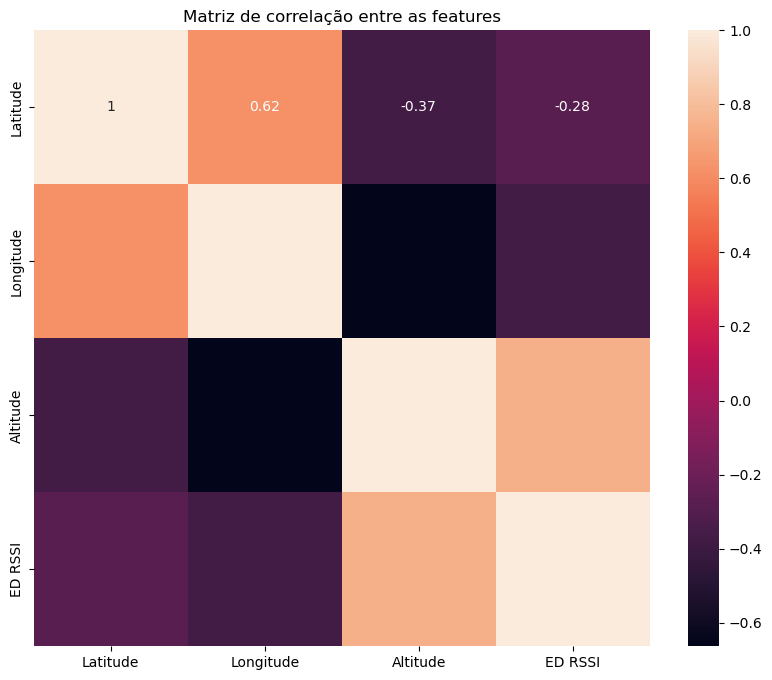

In [ ]:
# Matriz de correlação entre as features
plt.subplots(figsize=(10, 8))
plt.title('Matriz de correlação entre as features')
X = df_final.loc[:,['Latitude','Longitude','Altitude',
                    'ED RSSI', ]]
# RSSI,SNR,Frequency_Erro,Latitude,Longitude,Altitude,Velocidade_(km/h),Sentido_(graus),Satelites,Precisão_(centesimos de seg),Visada

sns.heatmap(X.corr(), vmax=1.0, square=True,annot=True)
# sns.heatmap(X.corr(), vmax=1.0, square=True,annot=True)

plt.savefig('Figuras/fig2 - Matriz correl após o feature selection')
plt.show()

Amostras com Visada: 572
Amostras sem Visada: 222


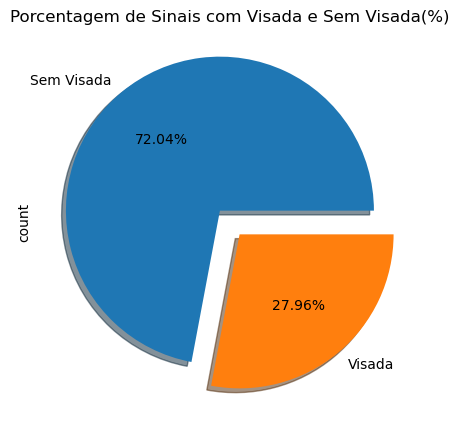

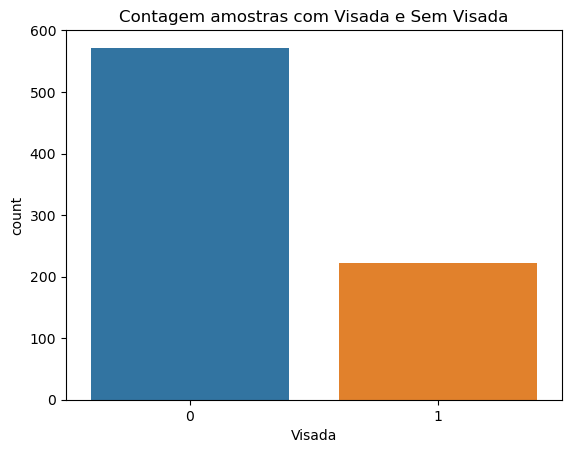

In [ ]:
visada, semvisada = df_final['Visada'].value_counts()
print(f'Amostras com Visada: {visada}')
print(f'Amostras sem Visada: {semvisada}')

labels1 = 'Sem Visada','Visada'
df_final['Visada'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels1, autopct='%1.2f%%',shadow=True,figsize=(5,5))
plt.title("Porcentagem de Sinais com Visada e Sem Visada(%)")
plt.savefig('Figuras/fig3 - Percentual')
plt.show()

plt.title("Contagem amostras com Visada e Sem Visada")
sns.countplot(data=df_final, x = 'Visada', label=['0 - Sem Visada', '1 - Com Visada'])
plt.savefig('Figuras/fig4 - Contagem ')


### Entrada

In [5]:
X = df_final.loc[:,['Latitude','Longitude','Altitude',
                    'ED RSSI',]]


y = df_final.loc[:,['Visada',]]

### KNN (K Nearest Neighbors)

In [6]:
#GridSearch

n_neighbors = [2, 3, 5, 7, 10, 15, 20]
weights = ['uniform', 'distance']
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_sizes = [15, 30, 50, 100]
ps = [1, 2, 3]

best_precision = 0
best_parameters = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
classification_time_list = []
score_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))

best_precision = 0
best_parameters_knn = []

with open('analise_results_knn.txt', 'a') as results:
    results.write("--- Modelo K Nearest Neighbors --- \n")

for n_neighbor in n_neighbors:
    for weight in weights:
        for algorithm in algorithms:
            for leaf_size in leaf_sizes:
                for p in ps:

                    for train_index, test_index in (kf.split(X)):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        Y_train, Y_test  = y[train_index], y[test_index]

                        start_time = time.time()
                        scaler = MinMaxScaler()
                        # scaler.fit(X_train)
                        X_train_normalized = scaler.fit_transform(X_train)

                        # scaler.fit(X_test)
                        X_test_normalized = scaler.transform(X_test)

                        knn = KNeighborsClassifier(n_neighbors = n_neighbor, weights=weight, algorithm=algorithm,
                        leaf_size=leaf_size, p=p).fit(X_train_normalized, Y_train)


                        y_pred = knn.predict(X_test_normalized)
                        end_time = time.time()

                        classification_time = (end_time - start_time) * 1000
                        score = knn.score(X_test_normalized, Y_test)
                        precision = precision_score(Y_test, y_pred)
                        recall = recall_score(Y_test, y_pred)
                        f1 = f1_score(Y_test, y_pred)

                        classification_time_list.append(classification_time)
                        score_list.append(score)
                        precision_list.append(precision)
                        recall_list.append(recall)
                        f1_list.append(f1)


                    classification_time_mean = np.mean(np.array(classification_time_list))
                    classification_time_std = np.std(np.array(classification_time_list))
                    score_mean = np.mean(np.array(score_list))
                    score_std = np.std(np.array(score_list))

                    precision_mean = np.mean(np.array(precision_list))
                    precision_std = np.std(np.array(precision_list))

                    recall_mean = np.mean(np.array(recall_list))
                    recall_std = np.std(np.array(recall_list))

                    f1_mean = np.mean(np.array(f1_list))
                    f1_std = np.std(np.array(f1_list))

                    classification_time_list = []
                    score_list = []
                    precision_list = []
                    recall_list = []
                    f1_list = []

                    # print("--------------\n Vizinho mais próximo (KNN)")
                    # print(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f})")
                    # print(f"Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f})")
                    # print(f"Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f})")
                    # print(f"F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f})")
                    with open('analise_results_knn.txt', 'a') as results:
                        results.write(f"Para n_neighbor = {n_neighbor}, weight = {weight}, algorithm = {algorithm}, leaf_size = {leaf_size} , p = {p}\n")
                        results.write(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f}), Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f}), Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f}), F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f}), Tempo médio (ms): {(classification_time_mean):.3f} +/- {(classification_time_std):.3f}\n")
                        results.close()

                    if ((precision_mean + precision_std <= 1.0) and (best_precision <= precision_mean)):
                        best_precision = precision_mean
                        best_parameters_knn = [n_neighbor, weight, algorithm, leaf_size, p]



In [7]:
print(f"Melhores hiperparâmetros: {best_parameters_knn}")

Melhores hiperparâmetros: [2, 'uniform', 'brute', 100, 2]


### MLP (Multi-Layer Perceptron)

In [12]:
#GridSearch

hidden_layer_sizes = [(1),(3), (5), (6),
                      (1, 1), (1, 3), (1, 5), (3, 3), (3, 5), (5, 5),
                      (1, 1, 1), (1, 3, 1), (1, 3, 3), (3, 1, 3), (3, 3, 3),]
activations = ['logistic', 'tanh', 'relu']
alphas = [0.0001, 0.001, 0.01, 0.1]
max_iters = [7000, 10000]
tols = [0.0001, 0.001, 0.01]

with open('analise_results_mlp.txt', 'a') as results:
    results.write("--- Modelo MLP --- \n")

results.close()

kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
classification_time_list = []
score_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))

best_precision = 0
best_parameters_mlp = []

for hidden_layer_size in hidden_layer_sizes:
    for activation in activations:
        for alpha in alphas:
            for max_iter in max_iters:
                for tol in tols:
                    for train_index, test_index in (kf.split(X)):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        Y_train, Y_test  = y[train_index], y[test_index]

                        start_time = time.time()
                        scaler = MinMaxScaler()
                           # scaler.fit(X_train)
                        X_train_normalized = scaler.fit_transform(X_train)

                            # scaler.fit(X_test)
                        X_test_normalized = scaler.transform(X_test)
                        
                        mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_size, activation=activation,
                                                random_state=42, max_iter=max_iter, alpha=alpha, verbose=False,
                                                solver='lbfgs', tol=tol).fit(X_train_normalized, Y_train)

                        y_pred = mlp_classifier.predict(X_test_normalized)
                        end_time = time.time()
                        classification_time = (end_time - start_time) * 1000
                        score = mlp_classifier.score(X_test_normalized, Y_test)
                        precision = precision_score(Y_test, y_pred)
                        recall = recall_score(Y_test, y_pred)
                        f1 = f1_score(Y_test, y_pred)

                        classification_time_list.append(classification_time)
                        score_list.append(score)
                        precision_list.append(precision)
                        recall_list.append(recall)
                        f1_list.append(f1)

                    classification_time_mean = np.mean(np.array(classification_time_list))
                    classification_time_std = np.std(np.array(classification_time_list))

                    score_mean = np.mean(np.array(score_list))
                    score_std = np.std(np.array(score_list))

                    precision_mean = np.mean(np.array(precision_list))
                    precision_std = np.std(np.array(precision_list))

                    recall_mean = np.mean(np.array(recall_list))
                    recall_std = np.std(np.array(recall_list))

                    f1_mean = np.mean(np.array(f1_list))
                    f1_std = np.std(np.array(f1_list))

                    score_list = []
                    classification_time_list = []
                    precision_list = []
                    recall_list = []
                    f1_list = []


                    # print("--------------\nRede Neural com multi camadas (MLP)")
                    # print(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f})")
                    # print(f"Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f})")
                    # print(f"Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f})")
                    # print(f"F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f})")

                    with open('analise_results_mlp.txt', 'a') as results:
                        results.write(f"Para hidden_layer = {hidden_layer_size}, activation = {activation}, alpha = {alpha}, max_iter = {max_iter} , tol = {tol}\n")
                        results.write(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f}), Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f}), Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f}), F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f}), Tempo médio (ms): ({(classification_time_mean):.3f}) +/- ({(classification_time_std):.3f})\n")                
                        results.close()

                    if ((precision_mean + precision_std <= 1.0) and (best_precision <= precision_mean)):
                        best_precision = precision_mean
                        best_parameters_mlp = [hidden_layer_size, activation, alpha, max_iter, tol]


print(f"Melhores parâmetros: {best_parameters_mlp}")

Melhores parâmetros: [(3, 3, 3), 'tanh', 0.1, 10000, 0.0001]


In [ ]:
print(f"Melhores hiperparâmetros: {best_parameters_mlp}")

Melhores hiperparâmetros: [(3, 3, 3), 'tanh', 0.1, 10000, 0.0001]


### SVM RBF (Suport Vector Machine Radius Base Forward)

In [5]:

Cs = [0.01, 0.1, 5, 10]
kernels = ['poly', 'rbf', 'sigmoid']
coefs0 = np.linspace(0, 30, 10)
tols =[0.0001, 0.001, 0.01]
gammas = ['scale', 'auto']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
classification_time_list = []
score_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))
best_precision = 0
best_parameters_svm = []

with open('analise_results_svm.txt', 'a') as results:
    results.write("--- Modelo SVM --- \n")

results.close()
for C in Cs:
    for kernel in kernels:
        for coef0 in coefs0:
           for tol in tols:
                for gamma in gammas:
                    for train_index, test_index in (kf.split(X)):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        Y_train, Y_test  = y[train_index], y[test_index]

                        start_time = time.time()
                        scaler = MinMaxScaler()
                        X_train_normalized = scaler.fit_transform(X_train)

                        X_test_normalized = scaler.transform(X_test)
                        svc_kbf = SVC(C=C, kernel=kernel, coef0=coef0, tol=tol, gamma=gamma).fit(X_train_normalized, Y_train)

                        end_time = time.time()
                        
                        classification_time = end_time - start_time
                        y_pred = svc_kbf.predict(X_test_normalized)
                        score = svc_kbf.score(X_test_normalized, Y_test)
                        precision = precision_score(Y_test, y_pred)
                        recall = recall_score(Y_test, y_pred)
                        f1 = f1_score(Y_test, y_pred)

                        i = i + 1
                        classification_time_list.append(classification_time)
                        score_list.append(score)
                        precision_list.append(precision)
                        recall_list.append(recall)
                        f1_list.append(f1)

                    classification_time_mean = np.mean(np.array(classification_time_list))
                    classification_time_std = np.std(np.array(classification_time_list))

                    score_mean = np.mean(np.array(score_list))
                    score_std = np.std(np.array(score_list))

                    precision_mean = np.mean(np.array(precision_list))
                    precision_std = np.std(np.array(precision_list))

                    recall_mean = np.mean(np.array(recall_list))
                    recall_std = np.std(np.array(recall_list))

                    f1_mean = np.mean(np.array(f1_list))
                    f1_std = np.std(np.array(f1_list))

                    classification_time_list.clear()
                    score_list.clear()
                    precision_list.clear()
                    recall_list.clear()
                    f1_list.clear()

                    # print(f"--------------\n SVM {C, kernel, coef0, tol, gamma} ")
                    # print(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f})")
                    # print(f"Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f})")
                    # print(f"Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f})")
                    # print(f"F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f})")

                    with open('analise_results_svm.txt', 'a') as results:
                        results.write(f"Para C = {C}, kernel = {kernel}, coef0 = {coef0}, tol = {tol}, gamma = {gamma}\n")
                        results.write(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f}), Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f}), Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f}), F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f}), Tempo médio (ms): {(classification_time_mean * 1000):.3f} +/- ({(classification_time_std *1000):.3f})\n")
                        results.close()

                    if ((precision_mean + precision_std <= 1.0) and (best_precision <= precision_mean)):
                        best_precision = precision_mean
                        best_parameters_svm = [C, kernel, coef0, tol, gamma]

    



In [7]:

Cs = [ 10]
kernels = ['rbf', 'sigmoid']
coefs0 = np.linspace(0, 50, 10)
tols =[0.0001, 0.001, 0.01]
gammas = ['scale', 'auto']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
classification_time_list = []
score_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))

for C in Cs:
    for kernel in kernels:
        for coef0 in coefs0:
           for tol in tols:
                for gamma in gammas:
                    for train_index, test_index in (kf.split(X)):
                        if(kernel == 'rbf'):
                            break
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        Y_train, Y_test  = y[train_index], y[test_index]

                        start_time = time.time()
                        scaler = MinMaxScaler()
                        X_train_normalized = scaler.fit_transform(X_train)

                        X_test_normalized = scaler.transform(X_test)
                        svc_kbf = SVC(C=C, kernel=kernel, coef0=coef0, tol=tol, gamma=gamma).fit(X_train_normalized, Y_train)

                        end_time = time.time()
                        
                        classification_time = end_time - start_time
                        y_pred = svc_kbf.predict(X_test_normalized)
                        score = svc_kbf.score(X_test_normalized, Y_test)
                        precision = precision_score(Y_test, y_pred)
                        recall = recall_score(Y_test, y_pred)
                        f1 = f1_score(Y_test, y_pred)

                        i = i + 1
                        classification_time_list.append(classification_time)
                        score_list.append(score)
                        precision_list.append(precision)
                        recall_list.append(recall)
                        f1_list.append(f1)

                    classification_time_mean = np.mean(np.array(classification_time_list))
                    classification_time_std = np.std(np.array(classification_time_list))

                    score_mean = np.mean(np.array(score_list))
                    score_std = np.std(np.array(score_list))

                    precision_mean = np.mean(np.array(precision_list))
                    precision_std = np.std(np.array(precision_list))

                    recall_mean = np.mean(np.array(recall_list))
                    recall_std = np.std(np.array(recall_list))

                    f1_mean = np.mean(np.array(f1_list))
                    f1_std = np.std(np.array(f1_list))

                    classification_time_list.clear()
                    score_list.clear()
                    precision_list.clear()
                    recall_list.clear()
                    f1_list.clear()

                    # print(f"--------------\n SVM {C, kernel, coef0, tol, gamma} ")
                    # print(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f})")
                    # print(f"Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f})")
                    # print(f"Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f})")
                    # print(f"F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f})")

                    with open('analise_results_svm.txt', 'a') as results:
                        results.write(f"Para C = {C}, kernel = {kernel}, coef0 = {coef0}, tol = {tol}, gamma = {gamma}\n")
                        results.write(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f}), Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f}), Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f}), F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f}), Tempo médio (ms): {(classification_time_mean * 1000):.3f} +/- ({(classification_time_std *1000):.3f})\n")
                        results.close()

                    if ((precision_mean + precision_std <= 1.0) and (best_precision <= precision_mean)):
                        best_precision = precision_mean
                        best_parameters_svm = [C, kernel, coef0, tol, gamma]

    



NameError: name 'best_precision' is not defined

In [8]:
print(f"Melhores hiperparâmetros: {best_parameters_svm}")

NameError: name 'best_parameters_svm' is not defined

In [13]:
#código do chat gpt

Cs = np.linspace(0.01, 10, 100)
kernels = ['poly', 'rbf', 'sigmoid']
coefs0 = np.linspace(0.1, 50, 10)
tols =[0.00001, 0.0001, 0.001, 0.01]
gammas = ['scale', 'auto']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
classification_time_list = []
score_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))
best_precision = 0
best_parameters_svm = []

# Variável para controlar o número de arquivos
file_counter = 1
results_file = f'analise_results_svm_{file_counter}.txt'

with open(results_file, 'a') as results:
    results.write("--- Modelo SVM --- \n")

@timeout_decorator.timeout(600)  # 600 segundos = 10 minutos
def evaluate_parameters(C, kernel, coef0, tol, gamma):
    global best_precision, best_parameters_svm
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        start_time = time.time()
        scaler = MinMaxScaler()
        X_train_normalized = scaler.fit_transform(X_train)
        X_test_normalized = scaler.transform(X_test)

        svc_kbf = SVC(C=C, kernel=kernel, coef0=coef0, tol=tol, gamma=gamma).fit(X_train_normalized, Y_train)

        end_time = time.time()
        classification_time = end_time - start_time
        y_pred = svc_kbf.predict(X_test_normalized)
        score = svc_kbf.score(X_test_normalized, Y_test)
        precision = precision_score(Y_test, y_pred)
        recall = recall_score(Y_test, y_pred)
        f1 = f1_score(Y_test, y_pred)

        classification_time_list.append(classification_time)
        score_list.append(score)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    classification_time_mean = np.mean(np.array(classification_time_list))
    classification_time_std = np.std(np.array(classification_time_list))

    score_mean = np.mean(np.array(score_list))
    score_std = np.std(np.array(score_list))

    precision_mean = np.mean(np.array(precision_list))
    precision_std = np.std(np.array(precision_list))

    recall_mean = np.mean(np.array(recall_list))
    recall_std = np.std(np.array(recall_list))

    f1_mean = np.mean(np.array(f1_list))
    f1_std = np.std(np.array(f1_list))

    classification_time_list.clear()
    score_list.clear()
    precision_list.clear()
    recall_list.clear()
    f1_list.clear()

    with open(results_file, 'a') as results:
        results.write(f"Para C = {C}, kernel = {kernel}, coef0 = {coef0}, tol = {tol}, gamma = {gamma}\n")
        results.write(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f}), Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f}), Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f}), F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f}), Tempo médio (ms): {(classification_time_mean * 1000):.3f} +/- ({(classification_time_std * 1000):.3f})\n")

    if (precision_mean + precision_std <= 1.0) and (best_precision <= precision_mean):
        best_precision = precision_mean
        best_parameters_svm = [C, kernel, coef0, tol, gamma]

def main():
    global file_counter, results_file
    for C in Cs:
        for kernel in kernels:
            for coef0 in coefs0:
                for tol in tols:
                    for gamma in gammas:
                        try:
                            evaluate_parameters(C, kernel, coef0, tol, gamma)
                        except timeout_decorator.TimeoutError:
                            with open(results_file, 'a') as results:
                                results.write(f"Timeout com C = {C}, kernel = {kernel}, coef0 = {coef0}, tol = {tol}, gamma = {gamma}\n")
                        except Exception as e:
                            with open(results_file, 'a') as results:
                                results.write(f"Erro com C = {C}, kernel = {kernel}, coef0 = {coef0}, tol = {tol}, gamma = {gamma}\n")
                                results.write(f"Erro: {e}\n")


if __name__ == "__main__":
    main()

In [6]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
score_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))


for train_index, test_index in (kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test  = y[train_index], y[test_index]


        scaler = MinMaxScaler()
        X_train_normalized = scaler.fit_transform(X_train)

        X_test_normalized = scaler.transform(X_test)
        svc_kbf = SVC(C=0.7163636363636363, kernel='rbf', coef0=44.455555555555556, tol=1e-05, gamma='auto').fit(X_train_normalized, Y_train)
        
        score = svc_kbf.score(X_test_normalized, Y_test)
        y_pred = svc_kbf.predict(X_test_normalized)
        precision = precision_score(Y_test, y_pred)
        recall = recall_score(Y_test, y_pred)
        f1 = f1_score(Y_test, y_pred)

        i = i + 1
        score_list.append(score)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

score_mean = np.mean(np.array(score_list))
score_std = np.std(np.array(score_list))

precision_mean = np.mean(np.array(precision_list))
precision_std = np.std(np.array(precision_list))

recall_mean = np.mean(np.array(recall_list))
recall_std = np.std(np.array(recall_list))

f1_mean = np.mean(np.array(f1_list))
f1_std = np.std(np.array(f1_list))


print("--------------\n SVM base radial")
print(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f})")
print(f"Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f})")
print(f"Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f})")
print(f"F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f})")



In [ ]:
print(f"Melhores hiperparâmetros MLP: {best_parameters_mlp}")

Melhores hiperparâmetros MLP: [3, 'logistic', 0.0001, 7000, 0.001]


### RF (Random Forest)

In [10]:
## GridSearch na mão 
n_estimators = [5, 10, 20, 40, 50, 75, 100]
criterions = ['gini','entropy','log_loss']
max_features = ['sqrt','log2', None]
classes_weight = ['balanced', 'balanced_subsample', None]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0
score_list = []
classification_time_list = []
precision_list = []
recall_list = []
f1_list = []
y = np.ravel(np.array(y))
best_precision = 0
best_parameters_rf = []

with open('analise_results_rf.txt', 'a') as results:
    results.write("--- Modelo Random Forest --- \n")

for n_estimator in n_estimators:
    for criterion in criterions:
        for max_feature in max_features:
            for class_weight in classes_weight:

                for train_index, test_index in (kf.split(X)):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        Y_train, Y_test  = y[train_index], y[test_index]

                        start_time = time.time()
                        scaler = MinMaxScaler()
                        # scaler.fit(X_train)
                        X_train_normalized = scaler.fit_transform(X_train)

                        # scaler.fit(X_test)
                        X_test_normalized = scaler.transform(X_test)
                        rfc = RandomForestClassifier(n_estimators=n_estimator, criterion=criterion, max_depth=None, min_samples_split=2,
                                                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=max_feature,
                                                    max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                                    n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=class_weight,
                                                    ccp_alpha=0.0, max_samples=None).fit(X_train_normalized, Y_train)
                        y_pred = rfc.predict(X_test_normalized)
                        end_time = time.time()
                        classification_time = (end_time - start_time) * 1000
                        score = rfc.score(X_test_normalized, Y_test)
                        precision = precision_score(Y_test, y_pred)
                        recall = recall_score(Y_test, y_pred)
                        f1 = f1_score(Y_test, y_pred)

                        i = i + 1
                        classification_time_list.append(classification_time)
                        score_list.append(score)
                        precision_list.append(precision)
                        recall_list.append(recall)
                        f1_list.append(f1)

                classification_time_mean = np.mean(np.array(classification_time_list))
                classification_time_std = np.std(np.array(classification_time_list))

                score_mean = np.mean(np.array(score_list))
                score_std = np.std(np.array(score_list))

                precision_mean = np.mean(np.array(precision_list))
                precision_std = np.std(np.array(precision_list))

                recall_mean = np.mean(np.array(recall_list))
                recall_std = np.std(np.array(recall_list))

                f1_mean = np.mean(np.array(f1_list))
                f1_std = np.std(np.array(f1_list))

                score_list = []
                classification_time_list = []
                precision_list = []
                recall_list = []
                f1_list = []

                # print("--------------\n Random Forest")
                # print(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f})")
                # print(f"Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f})")
                # print(f"Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f})")
                # print(f"F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f})")
                
                
                with open('analise_results_rf.txt', 'a') as results:
                    results.write(f"Para n_estimator = {n_estimator}, criterion = {criterion}, max_feature = {max_feature}, class_weight = {class_weight}\n")
                    results.write(f"Score: ({(score_mean * 100):.2f}) +/- ({(score_std * 100):.2f}), Precisão média: {(precision_mean * 100):.2f} +/- ({(precision_std * 100):.2f}), Recall médio: {(recall_mean * 100):.2f} +/- ({(recall_std * 100):.2f}), F1 médio: {(f1_mean * 100):.2f} +/- ({(f1_std * 100):.2f}), Tempo médio (ms): ({(classification_time_mean):.3f}) +/- ({(classification_time_std):.3f})\n")
                    results.close()

                if ((precision_mean + precision_std <= 1.0) and (best_precision <= precision_mean)):
                    best_precision = precision_mean
                    best_parameters_rf = [n_estimator, criterion, max_feature, class_weight]

results.close()

print(f"Melhores parâmetros: {best_parameters_rf}")

Melhores parâmetros: [20, 'entropy', 'log2', 'balanced_subsample']


In [11]:
print(f"Melhores hyperparâmetros para RF: {best_parameters_rf}")

Melhores hyperparâmetros para RF: [20, 'entropy', 'log2', 'balanced_subsample']


# Análise qualitativa

## Dataframe completo

#### Distância X RSSI

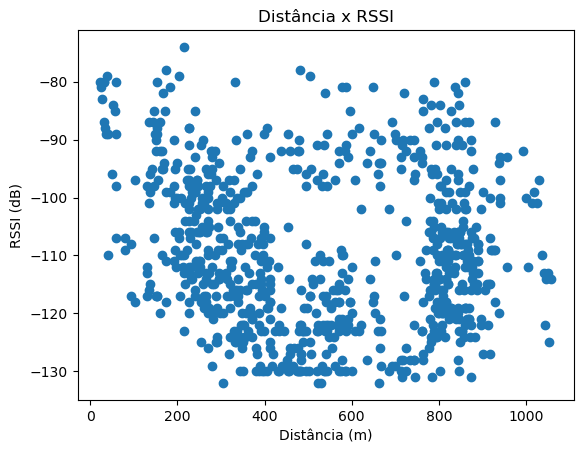

In [ ]:
df_final
# plt.scatter(df_final['ED RSSI'], df_final['Distância'])

plt.scatter(df_final['Distância'], df_final['ED RSSI'])
plt.title("Distância x RSSI")
plt.xlabel("Distância (m)")
plt.ylabel("RSSI (dB)")
plt.show()

#### Distância (log) x RSSI

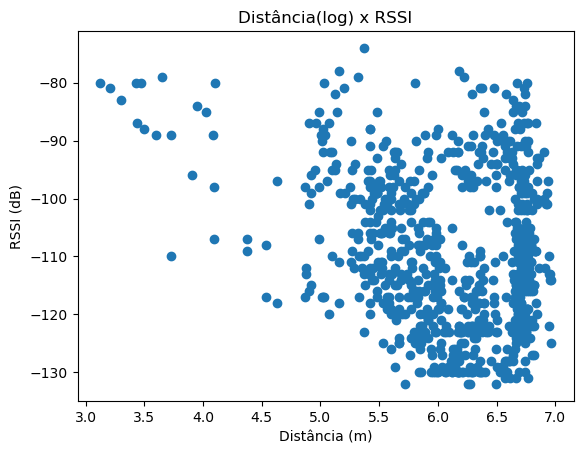

In [ ]:
# plt.scatter(df_final['ED RSSI'], df_final['Distância'])

plt.scatter(np.log(df_final['Distância']), df_final['ED RSSI'])
plt.title("Distância(log) x RSSI")
plt.xlabel("Distância (m)")
plt.ylabel("RSSI (dB)")
plt.show()

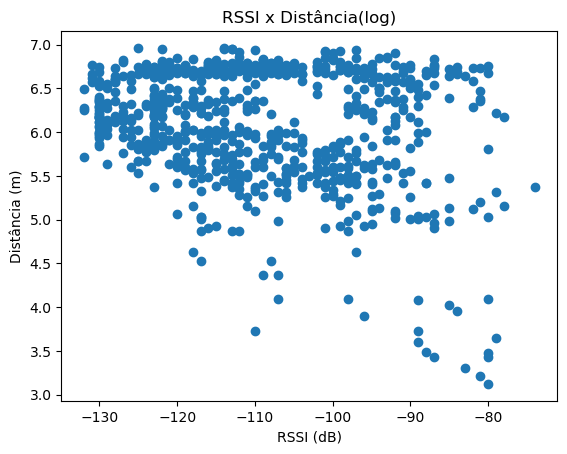

In [ ]:
# plt.scatter(df_final['ED RSSI'], df_final['Distância'])

plt.scatter(df_final['ED RSSI'], np.log(df_final['Distância']))
plt.title("RSSI x Distância(log)")
plt.ylabel("Distância (m)")
plt.xlabel("RSSI (dB)")
plt.show()

## LOS/NLOS destacados

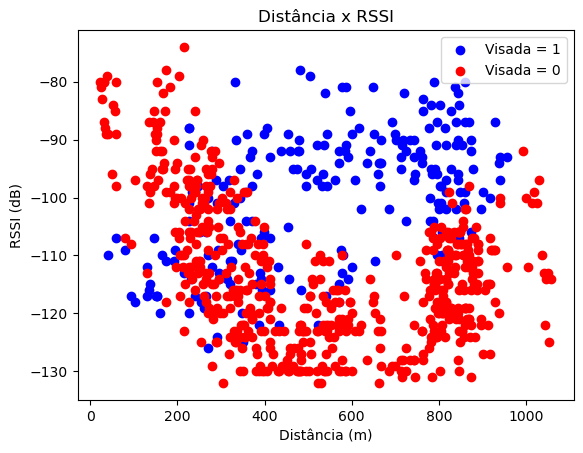

In [ ]:
df_visada_1 = df_final[df_final['Visada'] == 1]
df_visada_0 = df_final[df_final['Visada'] == 0]
plt.scatter(df_visada_1['Distância'], df_visada_1['ED RSSI'], color='blue', label='Visada = 1')
plt.scatter(df_visada_0['Distância'], df_visada_0['ED RSSI'], color='red', label='Visada = 0')
plt.legend()
plt.title("Distância x RSSI")
plt.xlabel("Distância (m)")
plt.ylabel("RSSI (dB)")
plt.show()

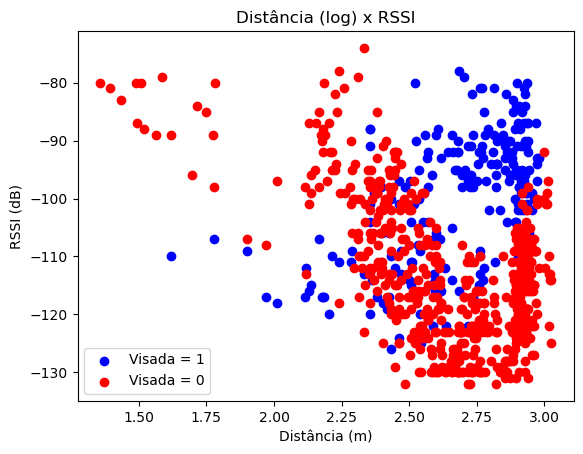

In [ ]:
df_visada_1 = df_final[df_final['Visada'] == 1]
df_visada_0 = df_final[df_final['Visada'] == 0]
plt.scatter(np.log10(df_visada_1['Distância']), df_visada_1['ED RSSI'], color='blue', label='Visada = 1')
plt.scatter(np.log10(df_visada_0['Distância']), df_visada_0['ED RSSI'], color='red', label='Visada = 0')
plt.legend()
plt.title("Distância (log) x RSSI")
plt.xlabel("Distância (m)")
plt.ylabel("RSSI (dB)")
plt.show()

In [ ]:
x_s_reg=d_s.reshape(-1, 1)
modelo = LinearRegression()
modelo.fit(x_s_reg, p_s)
p_s_reg = modelo.predict(x_s_reg)

,Time,GPS Time,id,Latitude,Longitude,Altitude,GPS Precision,# Satellites,ED RSSI,GW RSSI,Visada
0,18:44:32,21:44:24,33,-21.777797,-43.374139,918.7,1,14,-104,-85,1
1,18:44:40,21:44:32,34,-21.778067,-43.374374,921.1,1,14,-101,-97,1
2,18:45:13,21:45:04,38,-21.779387,-43.374631,922.3,1,14,-88,-87,1
3,18:45:21,21:45:13,39,-21.779459,-43.374125,923.9,1,14,-91,-84,1
4,18:45:29,21:45:21,40,-21.779385,-43.373685,924.6,1,14,-88,-76,1
...,...,...,...,...,...,...,...,...,...,...,...
217,17:00:09,20:00:00,519,-21.774011,-43.365992,897.0,1,14,-104,-85,1
218,14:13:03,17:12:55,10,-21.776171,-43.372281,939.8,1,13,-97,-94,1
219,14:13:11,17:13:03,11,-21.776194,-43.372281,939.8,1,13,-93,-91,1
220,14:13:19,17:13:11,12,-21.776232,-43.372291,939.9,1,13,-96,-95,1
